In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torch.autograd import Variable 

In [14]:
#prepare data
train_data = torchvision.datasets.MNIST(root="data/", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root="data/", train=False, transform=torchvision.transforms.ToTensor(), download=True)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


In [15]:
trainiter = iter(trainloader)
print(trainiter)

In [16]:
#data.train_labels will giv the numpy array
print(train_data.train_labels.shape)
print(train_data.train_data.shape)
print(test_data.test_data.shape)
print(test_data.test_labels.shape)

torch.Size([60000])
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    

In [18]:
network = Net().cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.98)
lr = 0.001
batch_size = 64
losses = []
accuracies = []
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(2 + 1)]


Where is an explicit connection between the optimizer and the loss?

How does the optimizer know where to get the gradients of the loss without a call liks this optimizer.step(loss)?

-More context-

When I minimize the loss, I didn't have to pass the gradients to the optimizer.

loss.backward() # Back Propagation
optimizer.step() # Gardient Descent




-Without delving too deep into the internals of pytorch, I can offer a simplistic answer:

Recall that when initializing optimizer you explicitly tell it what parameters (tensors) of the model it should be updating. The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss. After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored grad to update their values.

In [19]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(trainloader):
    data = data.to("cuda")
    target = target.to("cuda")
    
    #clear the gradients attatched to the parameters
    optimizer.zero_grad()
    #forward propagation
    output = network(data)
    #negative log-likelihood loss(no built-in softmax)
    #cross-entropy applies softmax 
    loss = F.nll_loss(output, target)
    #backpropagation
    loss.backward()
    #gradient descent and weight update
    optimizer.step()
    if batch_idx % 800 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      #loss.item() gives the value
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))


In [20]:
for i in range(10):
    train(i)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290064
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.523039
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.458150
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.248032
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.287581
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.296685
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.268558
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.162893
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.291990
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.183845
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.511724
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.171066
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.255337
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.330421
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.168495
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.083719
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.072245
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.108613
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.207169
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.149958


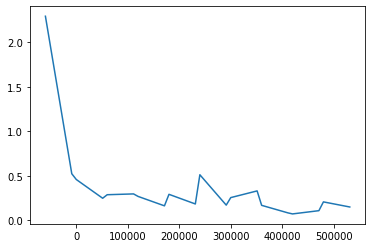

In [21]:
from matplotlib import pyplot as plt
plt.plot(train_counter, train_losses)
plt.show()


In [22]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  # deactivated autograd engine
  #notifies that we do not need to hold the gradients in the parameters
  #impacts memory utilization drastically during test
  with torch.no_grad():
    for data, target in testloader:
      data = data.to("cuda")
      target = target.to("cuda")
      output = network(data).to("cuda")
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))

In [23]:
test()


Test set: Avg. loss: 0.0518, Accuracy: 9834/10000 (98%)

